<center>
<p><img src="https://www.gob.mx/cms/uploads/image/file/179499/outstanding_quienes-somos.jpg" width="300">
</p>



# Curso *Machine Learning con uso de pandas, scikit learn y libretas jupyter*

# Pequeño taller datos diarios 


<p> Julio Waissman Vilanova </p>
<p>
<img src="https://identidadbuho.unison.mx/wp-content/uploads/2019/06/letragrama-cmyk-72.jpg" width="80">
</p>
</center>


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,7)

# Adquiriendo los datos

In [2]:
url = "https://github.com/juliowaissman/curso-ml-cenace/raw/main/datos/Dataset_GCRNO_05052021.xlsx"

df = pd.read_excel(url, sheet_name='Datos')
df_dic = pd.read_excel(url, sheet_name='Descripción de Variables')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5238 entries, 0 to 5237
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   FECHA             5238 non-null   datetime64[ns]
 1   DEM_GCRNO_H0      5238 non-null   float64       
 2   DEM_GCRNO_H1      5238 non-null   float64       
 3   DEM_GCRNO_H2      5238 non-null   float64       
 4   DEM_GCRNO_H3      5238 non-null   float64       
 5   DEM_GCRNO_H4      5238 non-null   float64       
 6   DEM_GCRNO_H5      5238 non-null   float64       
 7   DEM_GCRNO_H6      5238 non-null   float64       
 8   DEM_GCRNO_H7      5238 non-null   float64       
 9   DEM_GCRNO_H8      5238 non-null   float64       
 10  DEM_GCRNO_H9      5238 non-null   float64       
 11  DEM_GCRNO_H10     5238 non-null   float64       
 12  DEM_GCRNO_H11     5238 non-null   float64       
 13  DEM_GCRNO_H12     5238 non-null   float64       
 14  DEM_GCRNO_H13     5238 n

In [ ]:
df

In [ ]:
df_dic

Como vemos, se tiene la demanda por 24 horas, pero se encuentra en una misma columna. Si quisieramos utilizarlo para hacer el forecasting de la demanda integrada en forma horaria, necesitariamos cambiar esas columnas a instancias, lo que se puede hacer en pandas mas o menos fácil.

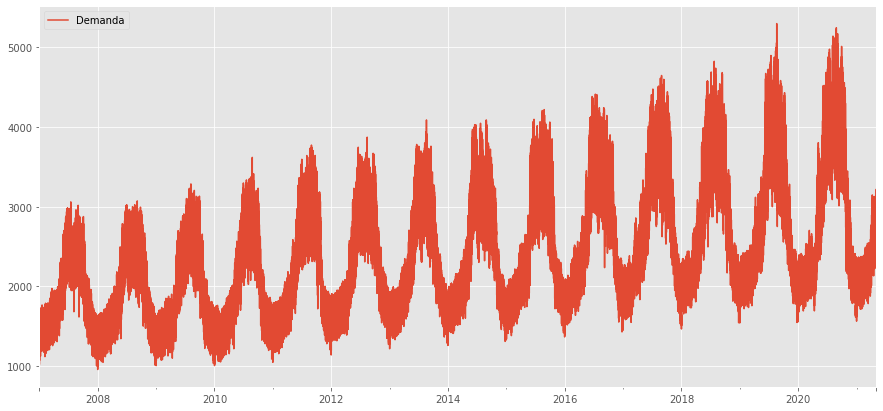

In [3]:
df_horario = df.melt(
    id_vars= ['FECHA'],
    value_vars= [f'DEM_GCRNO_H{i}' for i in range(24)],
    var_name="Hora",
    value_name="Demanda"
).replace(
    {f'DEM_GCRNO_H{i}': i for i in range(24)}
)

df_horario.index = df_horario.FECHA + pd.to_timedelta(df_horario.Hora, unit='h')
df_horario.sort_index(inplace=True)
df_horario.drop(columns=['FECHA', 'Hora'], inplace=True)

df_horario.plot(figsize=(15, 7))

# Análisis exploratorio de datos

1. ¿Cuales son las variables que interesan en un análisis diarios?
2. ¿Como se comporta la demanda máxima se acuerdo al mes?
3. ¿Que variación se tiene en demanda máxima y mínima por día de la semana?
4. ¿Que variaciones hay en el consumo integrado por hora?



In [ ]:
# Agrega cuantas celdas creas necesarias

## Forecasting

1. Definir un problema de *forecasting*
2. Probar con el uso de *skforcast*
3. Ajuster primero un modelo sencillo (`Ridge`) y luego ver que pasa con un modelo más complejo.


In [ ]:
# Agrega cuantas celdas consideres necesarias

## Una probadita a Prophet en rápido y furioso

In [ ]:
!pip install fbprophet

In [50]:
from fbprophet import Prophet

df_prophet = pd.DataFrame(
    {
        'ds': df_horario.index,
        'y': df_horario.Demanda
    }
)

modelo = Prophet().fit(df_prophet[df_prophet.ds.dt.year < 2021])

In [51]:
def stan_init(m):
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        res[pname] = m.params[pname][0][0]
    for pname in ['delta', 'beta']:
        res[pname] = m.params[pname][0]
    return res

In [59]:
future = modelo.make_future_dataframe(24, freq='h', include_history=False)
forecast = modelo.predict(future)

while forecast.ds.max() < df_prophet.ds.max():
  modelo = Prophet().fit(df_prophet[df_prophet.ds <= future.ds.max()], init=stan_init(modelo))
  future = modelo.make_future_dataframe(24, freq='h', include_history=False)
  forecast2 = modelo.predict(future)
  forecast = pd.concat([forecast, forecast2])
  

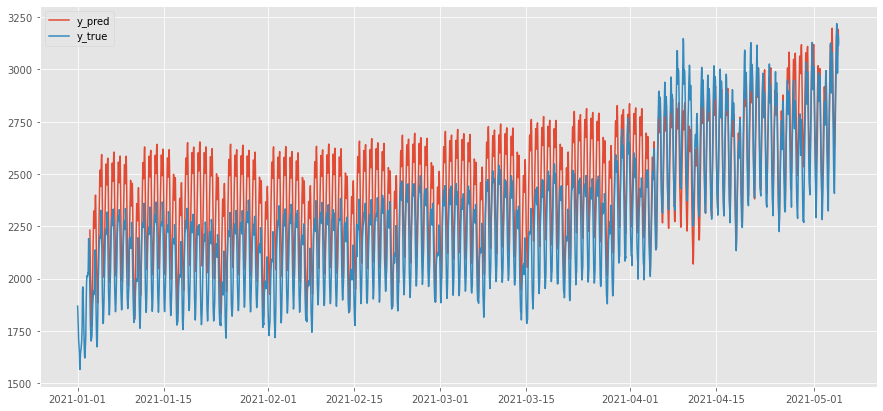

In [63]:
df_val = df_prophet[df_prophet.ds.dt.year==2021]

plt.plot(forecast.ds, forecast.yhat, label='y_pred')
plt.plot(df_val.ds, df_val.y, label='y_true')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



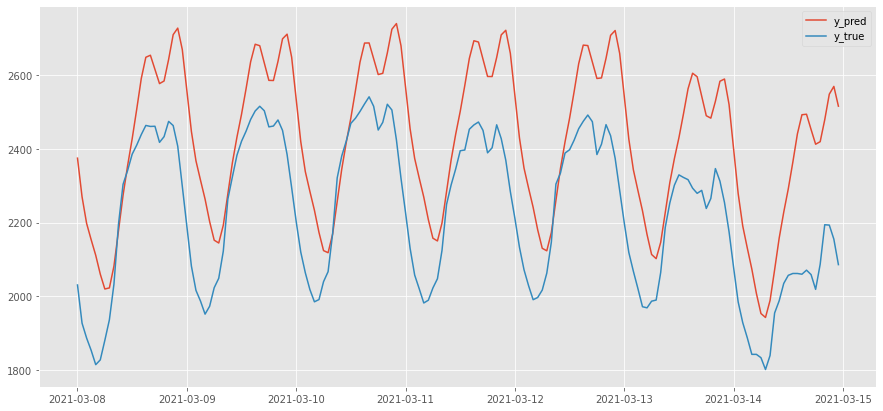

In [70]:
semana = 10

plt.plot(
    forecast.ds[forecast.ds.dt.weekofyear == semana], 
    forecast.yhat[forecast.ds.dt.weekofyear == semana], 
    label='y_pred')
plt.plot(
    df_val.ds[df_val.ds.dt.weekofyear == semana], 
    df_val.y[df_val.ds.dt.weekofyear == semana], 
    label='y_true')
plt.legend()
plt.show()